In [1]:
# https://pypi.org/project/tweet-preprocessor/
#https://github.com/5hirish/tweet_scrapper
#https://github.com/pablobarbera/pytwools
import preprocessor as p
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#import matplotlib
#matplotlib.use("Agg")
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.pyplot

In [2]:
#p.clean('Preprocessor is #awesome 👍 https://github.com/s/preprocessor 555555')

In [3]:
#p.tokenize('Preprocessor is #awesome 👍 https://github.com/s/preprocessor')

In [4]:
try:
    fulldata =pd.read_csv('Juul_Keywords-Tweets-Original.csv', lineterminator='\n',error_bad_lines=False)
    print("dataset has {} samples with {} features each.".format(*fulldata.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")
    

dataset has 614285 samples with 16 features each.


In [5]:
fulldata.head()

,tweet_id,text,retweet_count,favorite_count,created_at,hashtags,user_id,name,screen_name,description,verified,followers_count,friends_count,statuses_count,favourites_count,location
0,1100925907814871041,I just thought that my dad's USB was a Juul pe...,0,0,Thu Feb 28 01:09:25 +0000 2019,NaN,353191349,John,imjohnlee,"""I'm not a businessman, I'm a business, man""",0,99,140,4866,4689,USA
1,1100925823736074240,@crocNballs Pass a juul around under the stalls,0,1,Thu Feb 28 01:09:05 +0000 2019,NaN,1096516621043154950,dehd,dehdarse,private: @dehdd4,0,538,245,1865,1936,NaN
2,1100925726398779392,https://t.co/QxVRhhSPFQ,8,35,Thu Feb 28 01:08:42 +0000 2019,NaN,1100718090780925952,🏳️‍🌈⃠ shawny 🏳️‍🌈⃠,juul_shawny,The boy you love to hate,0,522,333,336,473,The Jewish Bermuda Triangle
3,1100925694685589504,Fiend Tip: Sit for 5 minute and spontaneously ...,0,1,Thu Feb 28 01:08:34 +0000 2019,NaN,3275140610,yurisicko,yurisicko,NaN,0,413,302,361,12784,Poland
4,1100925550732984320,Ned's Declassified Clown World Survival Guide,6,42,Thu Feb 28 01:08:00 +0000 2019,NaN,1100718090780925952,🏳️‍🌈⃠ shawny 🏳️‍🌈⃠,juul_shawny,The boy you love to hate,0,522,333,336,473,The Jewish Bermuda Triangle


In [6]:
Retweets_15 = fulldata.loc[(fulldata['retweet_count'] > 5) & (fulldata['favorite_count'] > 5)]

In [7]:
Retweets_15.shape

(7120, 16)

In [8]:
Retweets_15.head(5)

,tweet_id,text,retweet_count,favorite_count,created_at,hashtags,user_id,name,screen_name,description,verified,followers_count,friends_count,statuses_count,favourites_count,location
2,1100925726398779392,https://t.co/QxVRhhSPFQ,8,35,Thu Feb 28 01:08:42 +0000 2019,NaN,1100718090780925952,🏳️‍🌈⃠ shawny 🏳️‍🌈⃠,juul_shawny,The boy you love to hate,0,522,333,336,473,The Jewish Bermuda Triangle
4,1100925550732984320,Ned's Declassified Clown World Survival Guide,6,42,Thu Feb 28 01:08:00 +0000 2019,NaN,1100718090780925952,🏳️‍🌈⃠ shawny 🏳️‍🌈⃠,juul_shawny,The boy you love to hate,0,522,333,336,473,The Jewish Bermuda Triangle
126,1106679960633266177,No mom I don’t juul because I’m “addicted” I j...,7,28,Fri Mar 15 22:13:58 +0000 2019,NaN,804599980942131201,lil heirs,lilheirs,"healthy boy 😂💯, sicko thoughts 🥺😔",0,1629,1723,278,30933,"Minneapolis, MN"
180,1106672986722107392,Exclusive: India's health ministry calls for b...,17,67,Fri Mar 15 21:46:15 +0000 2019,NaN,1652541,Reuters Top News,Reuters,"Top and breaking news, pictures, and videos fr...",1,20292555,1082,369800,779,Around the world
478,1120537620424069120,Y’all mfs who are posting your vacation pics f...,7,12,Tue Apr 23 03:59:21 +0000 2019,NaN,543804154,a,_alexajordan_,ash is our purest form,0,458,306,11241,11780,MA


In [9]:
tweetsData = pd.DataFrame(Retweets_15, columns=['text'])
tweetsData.shape

(7120, 1)

In [10]:
tweetsData = tweetsData.dropna()
tweetsData = tweetsData.drop_duplicates(subset='text', keep="first")
tweetsData.shape

(7070, 1)

In [11]:
#Reserved words (RT, FAV)
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.SMILEY, p.OPT.RESERVED)#, p.OPT.NUMBER)

In [12]:
tweetsData.head()

,text
2,https://t.co/QxVRhhSPFQ
4,Ned's Declassified Clown World Survival Guide
126,No mom I don’t juul because I’m “addicted” I j...
180,Exclusive: India's health ministry calls for b...
478,Y’all mfs who are posting your vacation pics f...


In [13]:
clean_text = pd.DataFrame(tweetsData['text'].apply(lambda x: p.clean(x)))

In [14]:
clean_text_copy = clean_text.copy()

In [15]:
#clean_text = tweetsData['text'].apply(lambda x: p.clean(x))
#clean_text = pd.DataFrame(tweetsData['text'].apply(lambda x: p.clean(x)))

In [16]:
clean_text_copy.head()

,text
2,
4,Ned's Declassified Clown World Survival Guide
126,No mom I don’t juul because I’m “addicted” I j...
180,Exclusive: India's health ministry calls for b...
478,Y’all mfs who are posting your vacation pics f...


In [17]:
clean_text_copy.shape

(7070, 1)

In [18]:
clean_text_copy = clean_text_copy.drop_duplicates(subset='text', keep="first")
clean_text_copy.shape

(6920, 1)

In [19]:
#clean_text_copy = pd.DataFrame(clean_text_copy.dropna(axis=0))
#clean_text_copy.shape
clean_text_copy = clean_text_copy[clean_text_copy.text != '']

In [20]:
clean_text_copy.head()

,text
4,Ned's Declassified Clown World Survival Guide
126,No mom I don’t juul because I’m “addicted” I j...
180,Exclusive: India's health ministry calls for b...
478,Y’all mfs who are posting your vacation pics f...
522,edward scissor hands in his room after buying ...


In [21]:
clean_text_copy.shape

(6919, 1)

In [22]:
clean_text_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6919 entries, 4 to 614062
Data columns (total 1 columns):
text    6919 non-null object
dtypes: object(1)
memory usage: 108.1+ KB


## Pre-processing text data

Most of the text data are cleaned by following below steps.

    Remove punctuations
    Tokenization - Converting a sentence into list of words
    Remove stopwords
    Lammetization/stemming - Tranforming any form of a word to its root word

In [23]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())

clean_text_copy['word_count'] = clean_text_copy['text'].apply(word_count)

In [24]:
#clean_text_copy['word count'] = clean_text_copy['text'].apply(word_count)
clean_text_copy.head(5)

,text,word_count
4,Ned's Declassified Clown World Survival Guide,6
126,No mom I don’t juul because I’m “addicted” I j...,21
180,Exclusive: India's health ministry calls for b...,13
478,Y’all mfs who are posting your vacation pics f...,37
522,edward scissor hands in his room after buying ...,11


In [25]:
# Get a bool series representing which row satisfies the condition i.e. True for
# row in which value of 'Age' column is more than 30
minthreewords = clean_text_copy.apply(lambda x: True if x['word_count'] > 3 else False , axis=1)
 
# Count number of True in series
numOfRows = len(minthreewords[minthreewords == True].index)
 
print('Number of Rows in dataframe in which Age > 3 : ', numOfRows)

Number of Rows in dataframe in which Age > 3 :  6686


    Number of Rows in dataframe in which Age < 3 :  10766
    Number of Rows in dataframe in which Age > 3 :  542146
    Number of Rows in dataframe in which Age = 3 :  13310

In [26]:
minthreewords.head(5)

4      True
126    True
180    True
478    True
522    True
dtype: bool

In [27]:
selected_tweets_morethanthree = clean_text_copy.loc[clean_text_copy['word_count'] > 3]

In [28]:
selected_tweets_morethanthree.head()

,text,word_count
4,Ned's Declassified Clown World Survival Guide,6
126,No mom I don’t juul because I’m “addicted” I j...,21
180,Exclusive: India's health ministry calls for b...,13
478,Y’all mfs who are posting your vacation pics f...,37
522,edward scissor hands in his room after buying ...,11


In [29]:
selected_tweets_morethanthree.shape

(6686, 2)

In [30]:
#  Tokenize words and Clean-up text
# Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
# Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.
data = list(selected_tweets_morethanthree.text)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['ned', 'declassified', 'clown', 'world', 'survival', 'guide']]


In [31]:
# Creating Bigram and Trigram Models
# Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.
# Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.
# The higher the values of these param, the harder it is for words to be combined to bigrams.

# Build the bigram and trigram models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['ned', 'declassified', 'clown', 'world', 'survival', 'guide']


In [34]:
#  Remove Stopwords, Make Bigrams and Lemmatize
# The bigrams model is ready.
# Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.
# NLTK Stop words
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iKhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Let’s call the functions in order.

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [36]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [37]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import spacy
# I write the full name rather than en
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])

In [38]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [39]:
print(data_lemmatized[:1])

[['ned', 'declassify', 'clown', 'world', 'survival', 'guide']]


In [40]:
# Create the Dictionary and Corpus needed for Topic Modeling
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View

In [41]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [42]:
id2word[1]


'declassify'

In [43]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:100]]

[[('clown', 1),
  ('declassify', 1),
  ('guide', 1),
  ('ned', 1),
  ('survival', 1),
  ('world', 1)],
 [('addict', 1),
  ('always', 1),
  ('ass', 1),
  ('juul', 3),
  ('mom', 1),
  ('time', 1)],
 [('juul', 1),
  ('block', 1),
  ('call', 1),
  ('country', 1),
  ('document', 1),
  ('entry', 1),
  ('exclusive', 1),
  ('health', 1),
  ('india', 1),
  ('ministry', 1)],
 [('juul', 1),
  ('caption', 1),
  ('day', 1),
  ('earth', 2),
  ('eat', 1),
  ('everyday', 1),
  ('leave', 1),
  ('mfs', 1),
  ('nice', 1),
  ('one', 1),
  ('pic', 1),
  ('pod', 1),
  ('post', 1),
  ('steak', 1),
  ('throw', 1),
  ('vacation', 1),
  ('window', 1)],
 [('juul', 1),
  ('buy', 1),
  ('edward', 1),
  ('first', 1),
  ('hand', 1),
  ('room', 1),
  ('scissor', 1)],
 [('juul', 1),
  ('class', 1),
  ('drop', 1),
  ('fire', 1),
  ('fun', 1),
  ('get', 1),
  ('let', 1),
  ('light', 1),
  ('live', 1),
  ('start', 1),
  ('stream', 1),
  ('sub', 1),
  ('today', 1)],
 [('juul', 1),
  ('airpod', 1),
  ('meth', 1),
  ('mormo

In [44]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [45]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.038*"cigarette" + 0.023*"nicotine" + 0.019*"vap" + 0.014*"amp" + '
  '0.012*"addict" + 0.012*"teen" + 0.010*"cig" + 0.008*"product" + '
  '0.007*"high" + 0.007*"sell"'),
 (1,
  '0.052*"hit" + 0.011*"let" + 0.011*"not" + 0.010*"shit" + 0.010*"good" + '
  '0.010*"never" + 0.010*"need" + 0.010*"do" + 0.009*"put" + 0.008*"help"'),
 (2,
  '0.138*"juul" + 0.024*"pod" + 0.016*"get" + 0.015*"juuls" + 0.013*"go" + '
  '0.011*"smoke" + 0.009*"really" + 0.008*"make" + 0.008*"say" + '
  '0.007*"people"')]


In [46]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.783694925671665

Coherence Score:  0.3957046882862585


In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\iKhan\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.287317  0.008514       1        1  62.091480
1      0.134370 -0.201770       2        1  21.699707
0      0.152947  0.193256       3        1  16.208809, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
9     Default  5463.000000       juul  5463.000000  30.0000  30.0000
66    Default   710.000000        hit   710.000000  29.0000  29.0000
182   Default   388.000000  cigarette   388.000000  28.0000  28.0000
31    Default   951.000000        pod   951.000000  27.0000  27.0000
166   Default   235.000000   nicotine   235.000000  26.0000  26.0000
289   Default   196.000000        vap   196.000000  25.0000  25.0000
47    Default   646.000000        get   646.000000  24.0000  24.0000
311   Default   149.000000        amp   149.000000  23.0000  23.0000
176   Default   578.000000      juuls   578.000000  22.0000  22.0000
82    Default   528.000000         go   528.000000  21.0000  21.0000
48    Default   154.000000        let   154.000000  20.0000  20.0000
713   Default   150.000000        not   150.000000  19.0000  19.0000
6     Default   122.000000     addict   122.000000  18.0000  18.0000
216   Default   144.000000       shit   144.000000  17.0000  17.0000
195   Default   120.000000       teen   120.000000  16.0000  16.0000
134   Default   142.000000       good   142.000000  15.0000  15.0000
470   Default   139.000000      never   139.000000  14.0000  14.0000
332   Default   135.000000       need   135.000000  13.0000  13.0000
1209  Default   135.000000         do   135.000000  12.0000  12.0000
109   Default   417.000000      smoke   417.000000  11.0000  11.0000
484   Default   123.000000        put   123.000000  10.0000  10.0000
209   Default   102.000000        cig   102.000000   9.0000   9.0000
210   Default   111.000000       help   111.000000   8.0000   8.0000
719   Default   108.000000       feel   108.000000   7.0000   7.0000
409   Default   101.000000       come   101.000000   6.0000   6.0000
192   Default   339.000000     really   339.000000   5.0000   5.0000
92    Default   330.000000       make   330.000000   4.0000   4.0000
153   Default    79.000000    product    79.000000   3.0000   3.0000
313   Default    77.000000       high    77.000000   2.0000   2.0000
70    Default   309.000000        say   309.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
311    Topic3   148.661026        amp   149.548218   1.8137  -4.2379
6      Topic3   121.808327     addict   122.581337   1.8133  -4.4371
195    Topic3   119.504646       teen   120.322586   1.8128  -4.4562
153    Topic3    79.142639    product    79.751060   1.8120  -4.8683
209    Topic3   101.959404        cig   102.818153   1.8112  -4.6150
115    Topic3    67.603798      youth    68.216095   1.8106  -5.0259
358    Topic3    68.441055    tobacco    69.107559   1.8099  -5.0136
313    Topic3    77.041382       high    77.832588   1.8094  -4.8952
168    Topic3    71.175179       sell    71.911674   1.8093  -4.9744
463    Topic3    59.375397    company    59.994301   1.8092  -5.1557
59     Topic3    57.232372     smoker    57.899860   1.8080  -5.1924
570    Topic3    55.026798      study    55.669151   1.8080  -5.2317
352    Topic3    49.114017     market    49.732582   1.8071  -5.3454
1459   Topic3    44.223522        fda    44.860252   1.8053  -5.4503
507    Topic3    38.922726       sale    39.539654   1.8039  -5.5780
18     Topic3    39.085850     health    39.730923   1.8032  -5.5738
193    Topic3    38.805351      state    39.467468   1.8027  -5.5810
1597   Topic3    45.948402  addiction    46.771816   1.8019  -5.4120
1031   Topic3    34.497673         la    35.167007   1.8004  -5.6987
181    Topic3    37.397209      child    38.124683   1.8003  -5.6179
795    Topic3    30.603148   e

# Finding out the optimal number of topics
Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [48]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

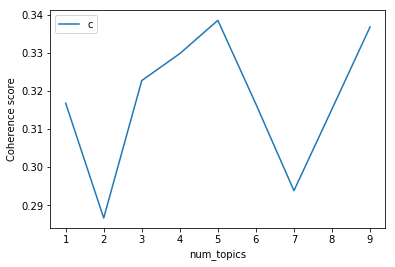

Wall time: 4min 43s


In [49]:
%%time
lmlist, c_v = evaluate_graph(dictionary=id2word, corpus=corpus, texts=data_lemmatized, limit=10)

In [50]:
pyLDAvis.gensim.prepare(lmlist[4], corpus, id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.003293  0.020373       1        1  26.238541
1     -0.147184  0.043293       2        1  24.505178
0      0.095758  0.083980       3        1  17.877989
2      0.038357 -0.010265       4        1  17.213562
4      0.009776 -0.137381       5        1  14.164732, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
31    Default   998.000000                 pod   998.000000  30.0000  30.0000
66    Default   758.000000                 hit   758.000000  29.0000  29.0000
166   Default   275.000000            nicotine   275.000000  28.0000  28.0000
176   Default   560.000000               juuls   560.000000  27.0000  27.0000
182   Default   475.000000           cigarette   475.000000  26.0000  26.0000
9     Default  5293.000000                juul  5293.000000  25.0000  25.0000
192   Default   261.000000              really   261.000000  24.0000  24.0000
82    Default   490.000000                  go   490.000000  23.0000  23.0000
4011  Default    97.000000            taehyung    97.000000  22.0000  22.0000
109   Default   394.000000               smoke   394.000000  21.0000  21.0000
274   Default   248.000000                know   248.000000  20.0000  20.0000
237   Default   202.000000                girl   202.000000  19.0000  19.0000
153   Default    86.000000             product    86.000000  18.0000  18.0000
360   Default   104.000000            everyone   104.000000  17.0000  17.0000
289   Default   234.000000                 vap   234.000000  16.0000  16.0000
750   Default    59.000000         high_school    59.000000  15.0000  15.0000
165   Default   169.000000                look   169.000000  14.0000  14.0000
302   Default   194.000000                 use   194.000000  13.0000  13.0000
582   Default    99.000000  nicotine_addiction    99.000000  12.0000  12.0000
266   Default    67.000000                 air    67.000000  11.0000  11.0000
477   Default   115.000000             someone   115.000000  10.0000  10.0000
139   Default   150.000000                stop   150.000000   9.0000   9.0000
79    Default   121.000000                 bro   121.000000   8.0000   8.0000
219   Default    89.000000               still    89.000000   7.0000   7.0000
124   Default   161.000000                 new   161.000000   6.0000   6.0000
713   Default   170.000000                 not   170.000000   5.0000   5.0000
879   Default    92.000000                mint    92.000000   4.0000   4.0000
70    Default   301.000000                 say   301.000000   3.0000   3.0000
576   Default   109.000000                quit   109.000000   2.0000   2.0000
648   Default    32.000000           crackhead    32.000000   1.0000   1.0000
...       ...          ...                 ...          ...      ...      ...
596    Topic5    19.764065                 app    25.568483   1.6969  -6.1209
192    Topic5   122.841232              really   261.136841   1.2003  -4.2938
1212   Topic5    17.024305               gross    23.386501   1.6369  -6.2701
237    Topic5    73.048882                girl   202.514587   0.9347  -4.8136
9      Topic5   643.216003                juul  5293.062988  -0.1533  -2.6383
124    Topic5    60.100349                 new   161.936050   0.9632  -5.0087
711    Topic5    27.164589                 can    49.963638   1.3450  -5.8028
86     Topic5    76.259438              people   278.990356   0.6574  -4.7706
1204   Topic5    23.587557                wake    44.203506   1.3263  -5.9440
514    Topic5    44.626087                 rip   135.162354   0.8463  -5.3064
114    Topic5    38.143555                year   105.696388   0.9352  -5.4634
339    Topic5    50.942032                find   184.333664   0.6684  -5.1741
461    Topic5    25.638893                 way    57.726791   1.1428 

In [51]:
from gensim.models.hdpmodel import HdpModel
#hdp = HdpModel(corpus=corpus,id2word=id2word)
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)
hdpmodel.show_topics()

[(0,
  '0.014*juul + 0.002*get + 0.002*smoke + 0.002*hit + 0.002*go + 0.002*say + 0.002*juuls + 0.002*amp + 0.002*do + 0.002*fuck + 0.002*kid + 0.002*girl + 0.002*guy + 0.002*use + 0.001*pod + 0.001*make + 0.001*come + 0.001*never + 0.001*cigarette + 0.001*thing'),
 (1,
  '0.011*juul + 0.002*pod + 0.002*hit + 0.002*go + 0.001*know + 0.001*get + 0.001*really + 0.001*need + 0.001*smoke + 0.001*cigarette + 0.001*juuls + 0.001*see + 0.001*tooth + 0.001*whole + 0.001*devastating + 0.001*let + 0.001*nicotine + 0.001*want + 0.001*lucrative + 0.001*shit'),
 (2,
  '0.009*juul + 0.002*get + 0.002*pod + 0.002*cigarette + 0.002*hit + 0.001*smoke + 0.001*smoking + 0.001*juuls + 0.001*think + 0.001*life + 0.001*go + 0.001*never + 0.001*gummy + 0.001*see + 0.001*even + 0.001*good + 0.001*weed + 0.001*new + 0.001*lui + 0.001*anyone'),
 (3,
  '0.009*juul + 0.002*pod + 0.001*get + 0.001*can + 0.001*picture + 0.001*make + 0.001*nicotine + 0.001*vape + 0.001*litter + 0.001*third + 0.001*lung + 0.001*trip 